In [12]:
from models.ICA_EM import *
from models.dgp import *
from models.metrics import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
n = 10000
J = 6
I = 5

In [3]:
def norm_funtion(A):
    # [0,0], [1,1] must be one
    A_0 = A[:, 0]/A[0,0]
    return A_0

In [4]:
noise_grid = np.linspace(0, 3, 10)
treatments_true = np.zeros((len(noise_grid), 30))
treatments_pred = np.zeros((len(noise_grid), 30))
ll_score = np.zeros((len(noise_grid), 30))
mse_score = np.zeros((len(noise_grid), 30))
fscore = np.zeros((len(noise_grid), 30))

In [16]:

for i in tqdm.tqdm(range(len(noise_grid))):
    data = dgp(noise_dict= {"loc" : 0, "scale" : noise_grid[i]}, prior= {"loc" : 0, "scale" : 1/np.sqrt(2)})
    for j in range(30):
        data.generate_data(n, I, J, random_state=j)
        est = CausalVarEM(update_sigma=False, true_A= data.mixing_matrix_observed, mode = "each")
        est.fit(data.data_observed, J, noise_params={"mean": 0, "std": noise_grid[i] if noise_grid[i] > 0 else 1}, progress_bar=False)
        treatments_true[i, j] = data.treatment_effect
        best_perm, score = f_score(data.mixing_matrix_observed, est.A)
        sorted_A = est.A[:, best_perm]
        treatments_pred[i, j] = norm_funtion(sorted_A)[1]
        ll_score[i, j] = likelihood_score(data.signals, est.Signals, true_paras={"mean": 0, "scale": 1/np.sqrt(2)})
        mse_score[i, j] = mean_squared_error(data.signals, est.Signals)
        fscore[i, j] = score




100%|██████████| 10/10 [1:51:21<00:00, 668.18s/it]


In [18]:
# save the results
for i in range(len(noise_grid)):
    df = pd.DataFrame({"treatments_true": treatments_true[i], "treatments_pred": treatments_pred[i], "ll_score": ll_score[i], "mse_score": mse_score[i], "fscore": fscore[i]})
    df.to_csv(f"results/increase_noise/CausalVarEM_{noise_grid[i]}.csv", index=False)

In [5]:
# load the results 
for i in range(len(noise_grid)):
    df = pd.read_csv(f"results/increase_noise/CausalVarEM_{noise_grid[i]}.csv")
    treatments_true[i] = df["treatments_true"].values
    treatments_pred[i] = df["treatments_pred"].values
    ll_score[i] = df["ll_score"].values
    mse_score[i] = df["mse_score"].values
    fscore[i] = df["fscore"].values

In [32]:
# remove one outlier
treatment_diff[1]

array([ 2.66545795e-01,  3.25596555e-01,  3.35901410e-01,  6.16091661e-01,
       -1.13958959e-01,  8.42492140e-01,  5.22472509e-01,  3.99933978e-01,
        8.96851237e-01,  2.00089507e+00,  1.30267009e+00,  1.59275424e-01,
        1.10581490e+00, -6.12437908e-02,  3.46067812e-01,  1.25936473e-01,
        8.10561279e-01,  6.80565573e-01,  1.60744962e-01,  1.31810498e+00,
       -1.76081806e+01,  1.05492667e+00,  6.56755130e-01,  4.45589397e-01,
        9.23015735e-01,  9.44435142e-01,  5.60316187e-01,  1.05368414e+00,
        2.74435419e-01,  4.87994626e-03])

<Axes: >

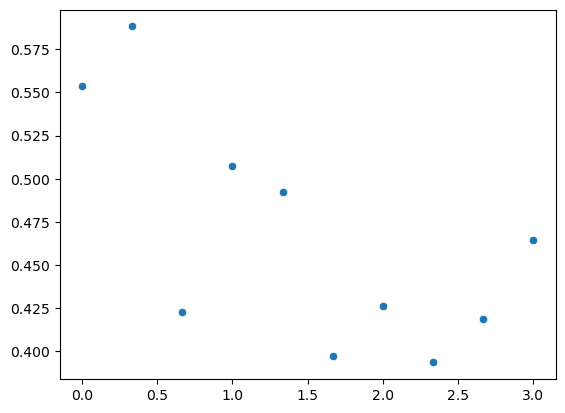

In [37]:
treatment_diff = (treatments_true - treatments_pred)
treatment_mse = np.median(np.abs(treatment_diff), axis=1)
sns.scatterplot(x=noise_grid, y=treatment_mse)

<Axes: >

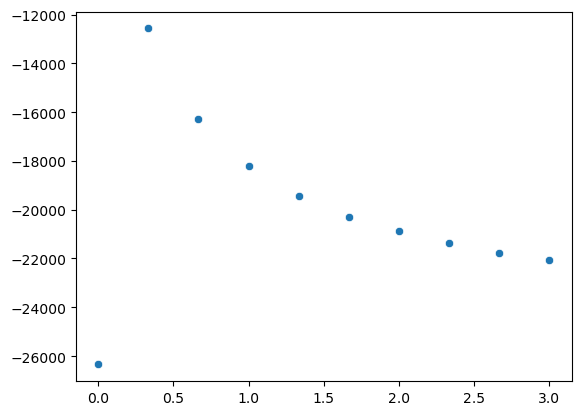

In [36]:
ll_score_mean = np.median(ll_score, axis=1)
sns.scatterplot(x=noise_grid, y=ll_score_mean)

<Axes: >

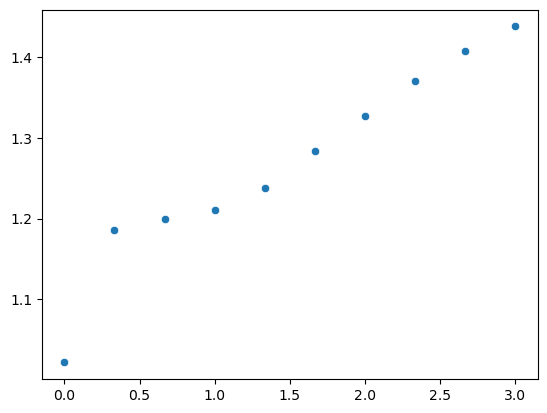

In [38]:
mse_score_mean = np.median(mse_score, axis=1)
sns.scatterplot(x=noise_grid, y=mse_score_mean)

<Axes: >

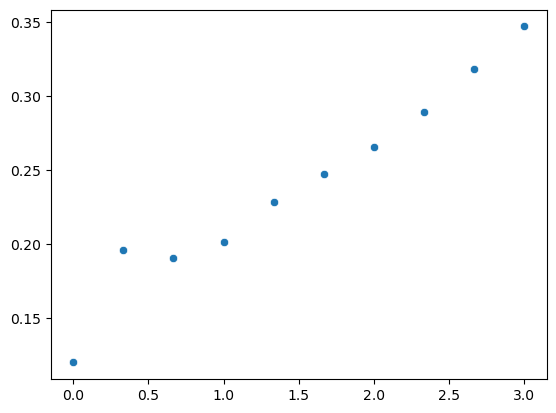

In [39]:
fscore_mean = np.median(fscore, axis=1)
sns.scatterplot(x=noise_grid, y=fscore_mean)